In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import RCN
import RCN_callable

# Part 4

## Q1

Estimate $\delta$ and $r$.

Load price list

In [3]:
data = pd.read_csv('Data-Project1-Fin404.csv')
data

,Strike,Call,Put
0,12000,381.525,1662.321
1,11800,420.599,1499.822
2,11600,493.332,1370.990
3,11400,571.380,1247.470
4,11200,649.428,1123.951
5,11000,727.476,1000.440
6,10800,805.524,876.917
7,10600,883.572,753.399
8,10400,991.344,659.605
9,10200,1114.862,581.557


Linear regression of call-put against strike

In [4]:
ols = sm.OLS(
    data.Call - data.Put,
    sm.add_constant(data.Strike)
).fit()
alpha, beta = ols.params

Derive values for $\delta$ and $r$

In [5]:
alpha/11118

0.9725845462577904

In [6]:
i0 = 11118
r = -np.log(-beta)
delta = np.exp(r) * (1 - alpha/i0)

print(
"""
r: {:.2%}%
delta: {:.2%}%
""".format(r, delta)
)


r: -0.78%%
delta: 2.72%%



## Q2

Calibrate the binomial model.

Define the value of the other know parameters.

In [7]:
# Other params
payment_dates = np.arange(1,13)
Delta = 30/360
q = 1/2
T = 12


            Best parameters:
                - up factor: 1.05472
                - down factor: 0.94398
            


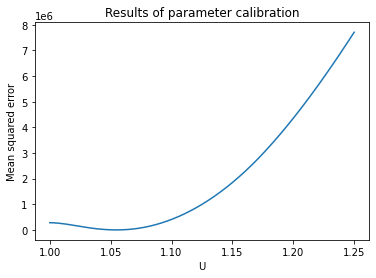

In [12]:
# Takes a bit to run

Us = np.arange(1., 1.25, .00001)
calibrator = RCN_callable.Binomial_calibrator(r, Delta, i0, delta, Us, q, T, data.Strike, data.Call)
best_U, best_D = calibrator.calibrate()

In [8]:
# best_U, best_D = 1.05472, 0.94398

# Part 5

## Q1

### i)

Simple RCN with maturity one year, monthly payments, annualized coupon rate $c= 10\%$ and strike $\alpha = 1$.

In [9]:
print("price: ${:.4f}".format(RCN.RCN_binomial(r, Delta, i0, delta, best_U, best_D, payment_dates, 0.1, 1., Simple=True, Callable=False, barrier_level=None).price_RCN()))

price: $1.0124


### ii)

Barrier-RCN with maturity one year, monthly payments, annualized coupon rate $c= 10\%$, strike $\alpha = 1$ and barrier $\beta= 0.8$.

In [11]:
print("price: ${:.4f}".format(RCN.RCN_binomial(r, Delta, i0, delta, best_U, best_D, payment_dates, 0.1, 1., Simple=False, Callable=False, barrier_level=0.8).price_RCN()))

price: $1.0545


## Q2

We define a `binary_search` function to compute par-parameters.

In [13]:
def binary_search(l, r, f, eps):
    left, right = l, r
    left_val, right_val = f(left), f(right)
    if left_val * right_val > 0:
        return np.nan
    else:
        while np.abs(right - left) > eps:
            mid = 0.5 * (left + right)
            mid_val = f(mid)
            if left_val * mid_val < 0:
                right = mid
                right_val = mid_val
            else:
                left = mid
                left_val = mid_val
        res = 0.5 * (left + right)
        return res

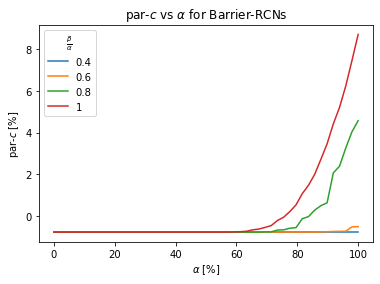

In [14]:
fig, ax = plt.subplots()
alphas = np.linspace(0., 1., 50)
for beta in [0.4, 0.6, 0.8, 1]:
    par_cs = []
    for alpha in alphas:
        f = lambda c: 1 - RCN.RCN_binomial(r, Delta, i0, delta, best_U, best_D, payment_dates, annualized_coupon=c, exercise_price=alpha, Simple=False, Callable=False, barrier_level=beta*alpha).price_RCN()
        par_c = binary_search(-0.2, 0.2, f, 0.0001)
        par_cs.append(par_c)
    ax.plot(alphas*100, np.array(par_cs)*100, label=beta)
ax.set(
    xlabel = r"$\alpha$ [%]",
    ylabel = r"par-$c$ [%]",
    title = r"par-$c$ vs $\alpha$ for Barrier-RCNs"
)
ax.legend(title = r"$\frac{\beta}{\alpha}$")
plt.show()

## Q3

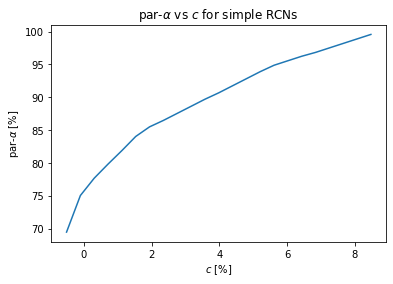

In [15]:
fig, ax = plt.subplots()
cs = np.linspace(-0.05, 0.15, 50)
par_alphas = []
for c in cs:
    f = lambda alpha: 1 - RCN.RCN_binomial(r, Delta, i0, delta, best_U, best_D, payment_dates, annualized_coupon=c, exercise_price=alpha, Simple=True, Callable=False, barrier_level=None).price_RCN()
    par_alpha = binary_search(0., 1., f, 0.001)
    par_alphas.append(par_alpha)
ax.plot(cs*100, np.array(par_alphas)*100)
ax.set(
    xlabel = r"$c$ [%]",
    ylabel = r"par-$\alpha$ [%]",
    title = r"par-$\alpha$ vs $c$ for simple RCNs"
)
plt.show()

## Q4

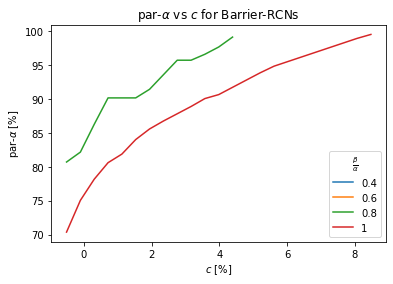

In [18]:
fig, ax = plt.subplots()
cs = np.linspace(-0.05, 0.15, 50)
for beta in [0.4, 0.6, 0.8, 1]:
    par_alphas = []
    for c in cs:
        f = lambda alpha: 1 - RCN.RCN_binomial(r, Delta, i0, delta, best_U, best_D, payment_dates, annualized_coupon=c, exercise_price=alpha, Simple=False, Callable=False, barrier_level=beta*alpha).price_RCN()
        par_alpha = binary_search(0., 1., f, 0.001)
        par_alphas.append(par_alpha)
    ax.plot(cs*100, np.array(par_alphas)*100, label=beta)
ax.set(
    xlabel = r"$c$ [%]",
    ylabel = r"par-$\alpha$ [%]",
    title = r"par-$\alpha$ vs $c$ for Barrier-RCNs"
)
ax.legend(title = r"$\frac{\beta}{\alpha}$")
plt.show()

## Q5

In [53]:
# fig, ax = plt.subplots()
# betas = np.linspace(0., 1., 50)
# par_alphas = []
# for beta in betas:
#     f = lambda alpha: 1 - RCN_binomial(r, Delta, i0, delta, best_U, best_D, 12, annualized_coupon=0.1, exercise_price=alpha, barrier_level=beta, _callable=False).price_RCN()
#     par_alpha = binary_search(0., 1., f, 0.001)
#     par_alphas.append(par_alpha)
# ax.plot(betas*100, np.array(par_alphas)*100)
# ax.set(
#     xlabel = r"$\beta$ [%]",
#     ylabel = r"par-$\alpha$ [%]",
#     title = r"par-$\alpha$ vs $\beta$ for simple RCNs"
# )
# plt.show()


## Q6

### i)

Callable simple RCN with maturity one year, monthly payments, annualized coupon rate $c= 10\%$ and strike $\alpha = 1$.

In [19]:
print("price: ${:.4f}".format(RCN_callable.RCN_binomial(r, Delta, i0, delta, best_U, best_D, 12, annualized_coupon=0.1, exercise_price=1, barrier_level=None, _callable=True).price_RCN()))

price: $0.9923


### ii)

Callable Barrier-RCN with maturity one year, monthly payments, annualized coupon rate $c= 10\%$, strike $\alpha = 1$ and barrier $\beta= 0.8$.

In [20]:
print("price: ${:.4f}".format(RCN_callable.RCN_binomial(r, Delta, i0, delta, best_U, best_D, 12, annualized_coupon=0.1, exercise_price=1, barrier_level=0.8, _callable=True).price_RCN()))

price: $0.9997


The exercise rule of the issuer is as follows:
- Compute the continuation value using the equivalent martingale
- if the continuation value is over 1 then call

which is why the current option price is:
$$
\min \left(\gamma \left(q P_{2 i, t+1} + (1-q)P_{2i+1, t+1} \right), 1 \right) + \Delta c \cdot \mathbf{1}_{\{t \neq 0 \}}
$$

Note: $\Delta c$ terms are there because one way or another, the issuer will have to pay the coupon (except at $t=0$)

## Q7

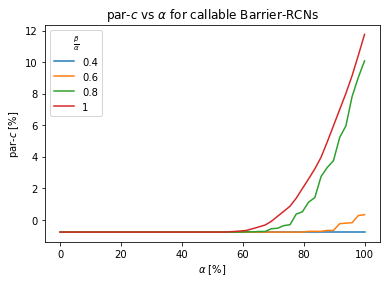

In [21]:
fig, ax = plt.subplots()
alphas = np.linspace(0., 1., 50)
for beta in [0.4, 0.6, 0.8, 1]:
    par_cs = []
    for alpha in alphas:
        f = lambda c: 1 - RCN_callable.RCN_binomial(r, Delta, i0, delta, best_U, best_D, 12, annualized_coupon=c, exercise_price=alpha, barrier_level=beta*alpha, _callable=True).price_RCN()
        par_c = binary_search(-0.2, 0.2, f, 0.0001)
        par_cs.append(par_c)
    ax.plot(alphas*100, np.array(par_cs)*100, label=beta)
ax.set(
    xlabel = r"$\alpha$ [%]",
    ylabel = r"par-$c$ [%]",
    title = r"par-$c$ vs $\alpha$ for callable Barrier-RCNs"
)
ax.legend(title = r"$\frac{\beta}{\alpha}$")
plt.show()

## Q8

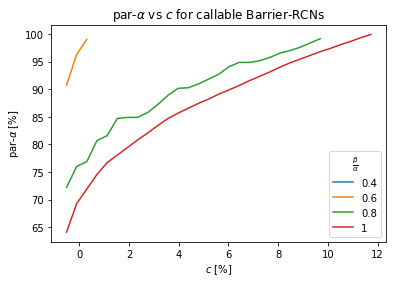

In [22]:
fig, ax = plt.subplots()
cs = np.linspace(-0.05, 0.15, 50)
for beta in [0.4, 0.6, 0.8, 1]:
    par_alphas = []
    for c in cs:
        f = lambda alpha: 1 - RCN_callable.RCN_binomial(r, Delta, i0, delta, best_U, best_D, 12, annualized_coupon=c, exercise_price=alpha, barrier_level=beta*alpha, _callable=True).price_RCN()
        par_alpha = binary_search(0., 1., f, 0.001)
        par_alphas.append(par_alpha)
    ax.plot(cs*100, np.array(par_alphas)*100, label=beta)
ax.set(
    xlabel = r"$c$ [%]",
    ylabel = r"par-$\alpha$ [%]",
    title = r"par-$\alpha$ vs $c$ for callable Barrier-RCNs"
)
ax.legend(title = r"$\frac{\beta}{\alpha}$")
plt.show()